In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from collections import Counter
from matplotlib.lines import Line2D

# **Pre-processing**

In [14]:
# get all data
df = pd.read_csv('https://raw.githubusercontent.com/Justin-Pascua/MATH-168-Group-Project/refs/heads/main/full_opensecrets_data.csv')

# filter down to top x-donors, where 0 <= x <= 100
x = 100
df = df.groupby('Senator').head(x).reset_index()
df

,index,Senator,Party,Organization,Total,PACs,Individuals
0,0,"Baldwin, Tammy",(D),University of Wisconsin,528258,0,528258
1,1,"Baldwin, Tammy",(D),JStreetPAC,216748,9706,207042
2,2,"Baldwin, Tammy",(D),Democracy Engine,187684,0,187684
3,3,"Baldwin, Tammy",(D),League of Conservation Voters,97896,12213,85683
4,4,"Baldwin, Tammy",(D),State of Wisconsin,91576,0,91576
...,...,...,...,...,...,...,...
9995,9995,"Young, Todd",(R),Hilton Worldwide,26825,2500,24325
9996,9996,"Young, Todd",(R),Mulzer Crushed Stone,26750,0,26750
9997,9997,"Young, Todd",(R),Pilot Corp,26700,0,26700
9998,9998,"Young, Todd",(R),North American Midway Entertainment,26600,0,26600


In [15]:
pivot_df = df.pivot_table(index='Senator', columns='Organization', values='Total', aggfunc='sum', fill_value=0)

In [16]:
normalized_data = normalize(pivot_df, norm='l2')

In [17]:
linked = linkage(normalized_data, method='ward')

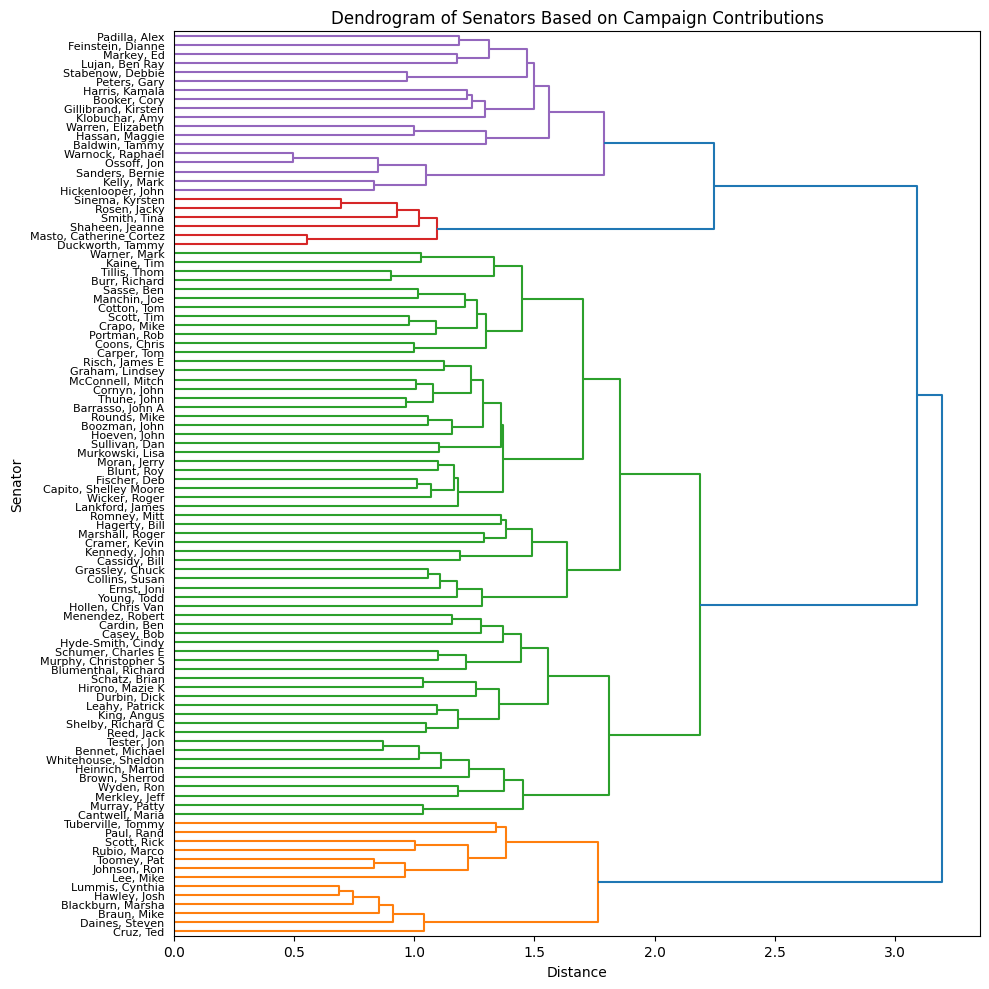

In [18]:
#Plot the dendrogram
plt.figure(figsize=(10, 10))
dendrogram(linked, labels=pivot_df.index.tolist(), orientation='right', leaf_font_size=8)
plt.title('Dendrogram of Senators Based on Campaign Contributions')
plt.xlabel('Distance')
plt.ylabel('Senator')
plt.tight_layout()
plt.show()

In [19]:
# compute normalized contributions (i.e. normalize donation amounts so that weighted degree of each senator is 1)

# initialize normalized columns
df['Portion of Total'] = 0.0
df['Portion of PACs'] = 0.0
df['Portion of Individuals'] = 0.0

# get unique names
senators = df['Senator'].unique()

for senator in senators:
  # get entries corresponding to fixed senator
  temp_df = df[df['Senator'] == senator].copy()

  # compute totals for PACs, Individuals, and Total column
  pacs_total = temp_df['PACs'].sum()
  individuals_total = temp_df['Individuals'].sum()
  combined_total = pacs_total + individuals_total

  # divide each entry with corresponding total
  df.loc[df['Senator'] == senator, 'Portion of Total'] = temp_df['Total']/combined_total
  df.loc[df['Senator'] == senator, 'Portion of PACs'] = temp_df['Individuals']/individuals_total
  df.loc[df['Senator'] == senator, 'Portion of Individuals'] = temp_df['PACs']/pacs_total

df

,index,Senator,Party,Organization,Total,PACs,Individuals,Portion of Total,Portion of PACs,Portion of Individuals
0,0,"Baldwin, Tammy",(D),University of Wisconsin,528258,0,528258,0.132522,0.188420,0.000000
1,1,"Baldwin, Tammy",(D),JStreetPAC,216748,9706,207042,0.054375,0.073848,0.008207
2,2,"Baldwin, Tammy",(D),Democracy Engine,187684,0,187684,0.047083,0.066943,0.000000
3,3,"Baldwin, Tammy",(D),League of Conservation Voters,97896,12213,85683,0.024559,0.030562,0.010327
4,4,"Baldwin, Tammy",(D),State of Wisconsin,91576,0,91576,0.022973,0.032664,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,9995,"Young, Todd",(R),Hilton Worldwide,26825,2500,24325,0.006222,0.007077,0.002861
9996,9996,"Young, Todd",(R),Mulzer Crushed Stone,26750,0,26750,0.006205,0.007782,0.000000
9997,9997,"Young, Todd",(R),Pilot Corp,26700,0,26700,0.006193,0.007768,0.000000
9998,9998,"Young, Todd",(R),North American Midway Entertainment,26600,0,26600,0.006170,0.007739,0.000000


# **Graph Construction**

Here, the edge between a donor and a politician in the bipartite graph is weighted by the fraction of the total campaign funds that the donor accounts for. For example, if a donor contributed \$1,000 to a politician, and that politician has a total of \$20,000 in campaign funds from all donors, then the corresponding edge would have weight 1/20

In [20]:
def construct_network(weight_by = 'Portion of Total'):
  # initialize graph
  bip_graph = nx.Graph()

  # add nodes for donors
  bip_graph.add_nodes_from(df['Organization'], bipartite = 0)

  # add nodes for senators
  bip_graph.add_nodes_from(df['Senator'], bipartite = 1)

  # get edges from df, weighted by normalized contributions
  edges = [(df['Organization'][i], df['Senator'][i], {'weight': df[weight_by][i]}) for i in range(len(df))]

  # add edges to graph
  bip_graph.add_edges_from(edges)

  row_nodes = list(df['Organization'].unique())
  col_nodes = list(df['Senator'].unique())

  # Get incidence matrix
  inc_matrix = nx.bipartite.biadjacency_matrix(bip_graph, row_nodes, col_nodes)

  # Get weighted adjacency matrices using incidence matrix
  senator_proj_matrix = inc_matrix.T @ inc_matrix
  donor_proj_matrix = inc_matrix @ inc_matrix.T

  # Convert into arrays
  senator_proj_matrix = senator_proj_matrix.toarray()
  donor_proj_matrix = donor_proj_matrix.toarray()

  # Create projections using adjacency matrices
  senator_network = nx.from_numpy_array(senator_proj_matrix)
  donor_network = nx.from_numpy_array(donor_proj_matrix)

  # Add weighted degree to attributes of each node
  for i in range(100):
    senator_network.nodes[i]['Weighted Degree'] = senator_proj_matrix[i].sum()

  for i in donor_network.nodes:
    donor_network.nodes[i]['Weighted Degree'] = donor_proj_matrix[i].sum()

  return bip_graph, senator_proj_matrix, donor_proj_matrix, senator_network, donor_network

Below, we list the edges (and the corresponding pair of senators that are joined by that edge) sorted from highest weight to lowest

# **Dendrogram**

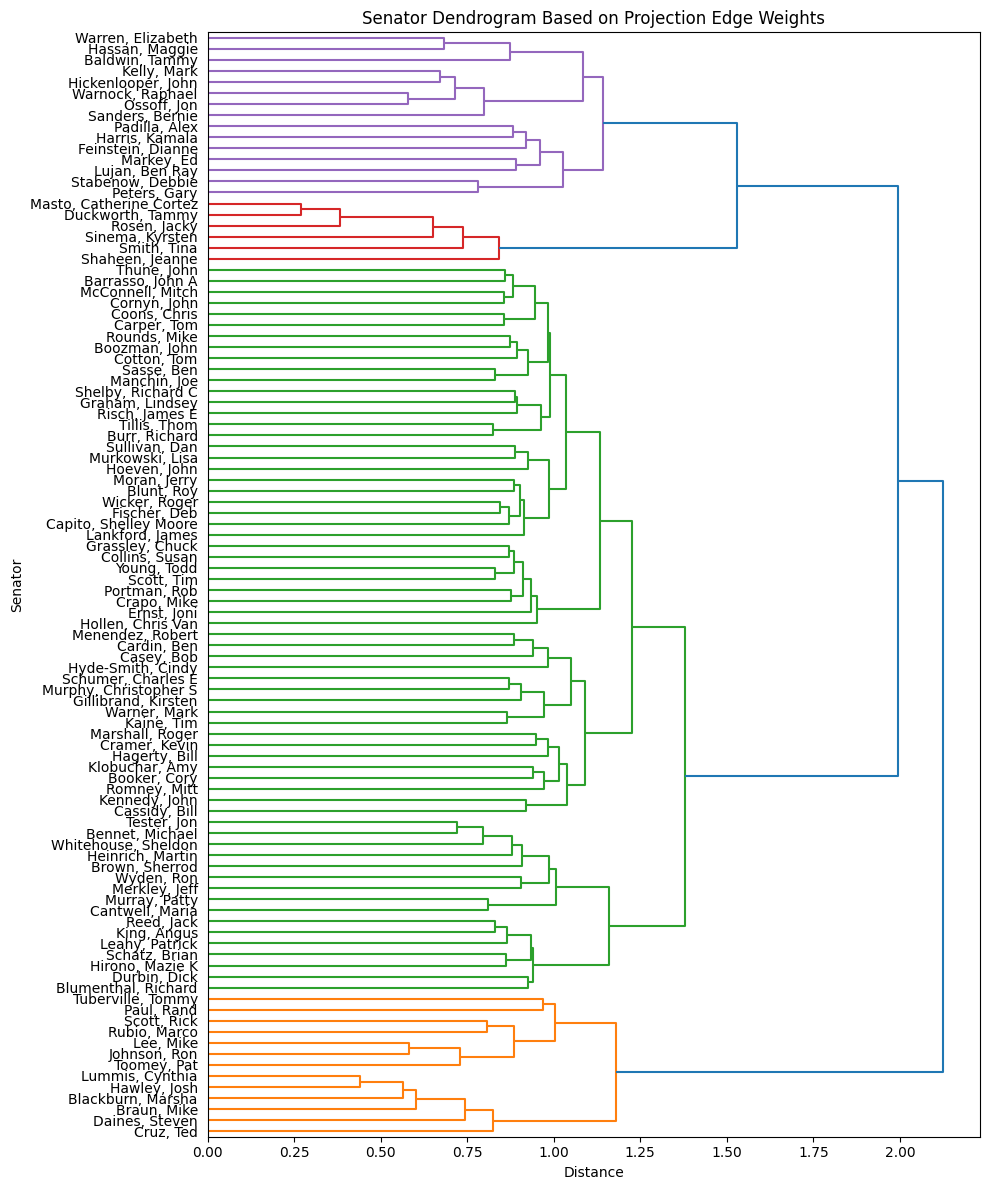

In [28]:
# Step 2: Normalize contributions
df['Portion of Total'] = 0.0
for senator in df['Senator'].unique():
    temp_df = df[df['Senator'] == senator]
    pacs_total = temp_df['PACs'].sum()
    individuals_total = temp_df['Individuals'].sum()
    total = pacs_total + individuals_total
    if total > 0:
        df.loc[df['Senator'] == senator, 'Portion of Total'] = temp_df['Total'] / total

# Step 3: Create a bipartite graph and compute senator projection
bip_graph = nx.Graph()
bip_graph.add_nodes_from(df['Organization'], bipartite=0)
bip_graph.add_nodes_from(df['Senator'], bipartite=1)

# Add weighted edges
edges = [(row['Organization'], row['Senator'], {'weight': row['Portion of Total']}) for _, row in df.iterrows()]
bip_graph.add_edges_from(edges)

row_nodes = df['Organization'].unique()
col_nodes = df['Senator'].unique()

# Incidence matrix and projection
inc_matrix = nx.bipartite.biadjacency_matrix(bip_graph, row_nodes, col_nodes, weight='weight')
proj_matrix = inc_matrix.T @ inc_matrix
proj_matrix = proj_matrix.toarray()

# Step 4: Build similarity matrix from edge weights
similarity_matrix = proj_matrix.copy()

# Step 5: Convert to distance matrix (normalize and invert)
max_sim = np.max(similarity_matrix)
distance_matrix = 1 - (similarity_matrix / max_sim)
np.fill_diagonal(distance_matrix, 0)  # ensure diagonal is zero
condensed_distance = squareform(distance_matrix)

# Step 6: Hierarchical clustering and dendrogram
linked_ward = linkage(condensed_distance, method='ward')

party_lookup = dict(zip(df['Senator'], df['Party']))
party_colors = {'(D)': 'blue', '(R)': 'red', '(I)': 'green'}

# Number of clusters you want to identify
num_clusters = 4

# 1. Assign senators to clusters
flat_clusters = fcluster(linked_ward, num_clusters, criterion='maxclust')
senator_to_cluster = {name: cluster for name, cluster in zip(col_nodes, flat_clusters)}

# 2. Determine the dominant party in each cluster
cluster_to_party = {}
for cluster_id in range(1, num_clusters + 1):
    members = [name for name, c in senator_to_cluster.items() if c == cluster_id]
    parties = [party_lookup.get(name, '(I)') for name in members]
    majority_party = Counter(parties).most_common(1)[0][0]
    cluster_to_party[cluster_id] = majority_party

# 3. Map party to branch color
branch_color_map = {'(D)': 'blue', '(R)': 'red', '(I)': 'green'}
def branch_color_func(link_index):
    if link_index < len(col_nodes):
        name = col_nodes[link_index]
        cluster_id = senator_to_cluster.get(name)
    else:
        cluster_id = flat_clusters[link_index - len(col_nodes)]
    party = cluster_to_party.get(cluster_id, '(I)')
    return branch_color_map.get(party, 'gray')

plt.figure(figsize=(10, 12))
dendrogram(
    linked,
    labels=col_nodes,
    orientation='right',
    leaf_font_size=10
)
plt.title('Senator Dendrogram Based on Projection Edge Weights')
plt.xlabel('Distance')
plt.ylabel('Senator')
plt.tight_layout()
plt.show()

# Step 2: Normalize contributions
df['Portion of Total'] = 0.0
for senator in df['Senator'].unique():
    temp_df = df[df['Senator'] == senator]
    pacs_total = temp_df['PACs'].sum()
    individuals_total = temp_df['Individuals'].sum()
    total = pacs_total + individuals_total
    if total > 0:
        df.loc[df['Senator'] == senator, 'Portion of Total'] = temp_df['Total'] / total

# Step 3: Build the bipartite graph and project it onto senators
bip_graph = nx.Graph()
bip_graph.add_nodes_from(df['Organization'], bipartite=0)
bip_graph.add_nodes_from(df['Senator'], bipartite=1)

edges = [(row['Organization'], row['Senator'], {'weight': row['Portion of Total']}) for _, row in df.iterrows()]
bip_graph.add_edges_from(edges)

row_nodes = df['Organization'].unique()
col_nodes = df['Senator'].unique()  # This will define senator order

# Incidence matrix and projection
inc_matrix = nx.bipartite.biadjacency_matrix(bip_graph, row_nodes, col_nodes, weight='weight')
proj_matrix = inc_matrix.T @ inc_matrix
proj_matrix = proj_matrix.toarray()

# Step 4: Convert projection similarity matrix to distance matrix
similarity_matrix = proj_matrix.copy()
max_sim = np.max(similarity_matrix)
distance_matrix = 1 - (similarity_matrix / max_sim)
np.fill_diagonal(distance_matrix, 0)
condensed_distance = squareform(distance_matrix)

# Step 5: Perform hierarchical clustering using Ward’s method
linked_ward = linkage(condensed_distance, method='ward')

# Step 6: Build a party lookup dictionary
party_lookup = dict(zip(df['Senator'], df['Party']))
party_colors = {'(D)': 'blue', '(R)': 'red', '(I)': 'green'}

# Step 7: Assign each senator to a cluster
num_clusters = 4
flat_clusters = fcluster(linked_ward, num_clusters, criterion='maxclust')
senator_to_cluster = {name: cluster for name, cluster in zip(col_nodes, flat_clusters)}

# Step 8: Determine dominant party in each cluster
cluster_to_party = {}
for cluster_id in range(1, num_clusters + 1):
    members = [name for name, c in senator_to_cluster.items() if c == cluster_id]
    parties = [party_lookup.get(name, '(I)') for name in members]
    majority_party = Counter(parties).most_common(1)[0][0]
    cluster_to_party[cluster_id] = majority_party

# Step 9: Define function to color branches based on cluster party
def branch_color_func(link_index):
    if link_index < len(col_nodes):
        name = col_nodes[link_index]
        cluster_id = senator_to_cluster.get(name)
    else:
        cluster_id = flat_clusters[link_index - len(col_nodes)]
    party = cluster_to_party.get(cluster_id, '(I)')
    return party_colors.get(party, 'gray')

# Step 10: Plot the dendrogram
plt.figure(figsize=(14, 10))
dendrogram(
    linked_ward,
    labels=col_nodes,
    orientation='right',
    leaf_font_size=10,
    link_color_func=lambda k: branch_color_func(k)
)

# Add legend for party colors
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='Democrat (D)'),
    Line2D([0], [0], color='red', lw=4, label='Republican (R)'),
    Line2D([0], [0], color='green', lw=4, label='Independent (I)')
]
plt.legend(handles=legend_elements, loc='upper right', title='Majority Party in Cluster')

plt.title("Senator Dendrogram Colored by Dominant Party (Ward’s Method)")
plt.xlabel("Distance")
plt.ylabel("Senator")
plt.tight_layout()
plt.show()